## Установка библиотек

In [ ]:
!pip install catboost

In [ ]:
!pip install optuna

In [ ]:
!!pip install transformers

In [ ]:
!pip install datasets

In [ ]:
!pip install lightgbm

In [ ]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import string
import re
import shutil

%matplotlib inline

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import recall_score
from sklearn.linear_model import LinearRegression, LogisticRegression

In [68]:
from catboost import CatBoostClassifier

In [ ]:
from xgboost import XGBClassifier

In [ ]:
from lightgbm import LGBMClassifier

In [5]:
import torch

In [6]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import TrainingArguments, Trainer

from datasets import load_dataset, Dataset
from datasets import load_metric

import nltk 
from nltk.corpus import stopwords

## EDA

In [ ]:
train = pd.read_csv("train_dataset_train.csv")
test = pd.read_csv("test_dataset_test.csv")

In [ ]:
train.head(3)

,RecordNo,Название книги,Автор,Ссылка на литрес,Рейтинг,Количество оценок,Количество отзывов,Имя читателя,Оценка книги читателем (из 5 баллов),Отзыв,Лайки на отзыв,Дислайки на отзыв,Релевантность,Таксономия релевантные,Таксономия не релевантные,Длина отзыва,Ценности
0,6145,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.7,3922,408,Айгуль Ляпина,5.0,Рекомендую книгу в прочтению/прослушиванию. Ес...,0,3,0,0,0,0,0
1,7006,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.6,24719,2103,Olga T,5.0,"Удивительно, что сейчас возникает ТАКАЯ литера...",0,1,0,0,0,0,1
2,1124,Дети мои,Гузель Яхина,https://www.litres.ru/guzel-yahina/deti-moi/,4.4,8032,702,Кирилл Чириков,5.0,"Душевно, жизненно, чувственно, проникновенно!!...",0,0,0,1,0,0,1


In [ ]:
train.info()

In [ ]:
train.describe()

,RecordNo,Автор,Рейтинг,Количество оценок,Количество отзывов,Оценка книги читателем (из 5 баллов),Лайки на отзыв,Дислайки на отзыв,Релевантность,Таксономия релевантные,Таксономия не релевантные,Длина отзыва,Ценности,Длина отзыва (числ.)
count,4839.000000,4839.000000,4839.000000,4839.000000,4839.000000,4839.000000,4839.000000,4839.000000,4839.000000,4839.000000,4839.000000,4839.000000,4839.000000,4839.000000
mean,4022.292829,25.320107,4.504546,8864.133499,764.269890,4.422815,4.025832,1.790453,0.218640,0.512296,0.126886,0.234759,0.542054,335.560240
std,2297.657785,8.916534,0.189645,9956.818440,841.728494,0.966889,26.075881,10.973393,0.413367,0.499900,0.332879,0.423892,0.498280,344.711384
min,2.000000,0.000000,3.200000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2042.000000,23.000000,4.400000,1212.000000,113.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,171.000000
50%,4058.000000,23.000000,4.600000,3551.000000,285.000000,5.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,235.000000
75%,6028.000000,28.000000,4.600000,24719.000000,2103.000000,5.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,377.000000
max,7960.000000,58.000000,5.000000,24719.000000,2103.000000,5.000000,874.000000,459.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6028.000000


In [ ]:
test.describe()

,Автор,Рейтинг,Количество оценок,Количество отзывов,Оценка книги читателем (из 5 баллов),Лайки на отзыв,Дислайки на отзыв,Длина отзыва (числ.)
count,2075.000000,2075.000000,2075.000000,2075.000000,2075.000000,2075.000000,2075.000000,2075.000000
mean,21.924337,4.504964,8655.117590,746.907470,4.418313,3.956627,1.722892,341.235181
std,8.502740,0.197744,9850.412201,832.518551,0.984671,18.704190,7.458521,405.514266
min,0.000000,3.200000,1.000000,1.000000,1.000000,0.000000,0.000000,59.000000
25%,19.000000,4.400000,1212.000000,110.000000,4.000000,0.000000,0.000000,168.000000
50%,19.000000,4.600000,3551.000000,285.000000,5.000000,0.000000,1.000000,233.000000
75%,24.000000,4.600000,24719.000000,2103.000000,5.000000,2.000000,1.000000,376.000000
max,51.000000,5.000000,24719.000000,2103.000000,5.000000,361.000000,247.000000,8402.000000


In [97]:
rating = test["Оценка книги читателем (из 5 баллов)"].fillna(4.5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


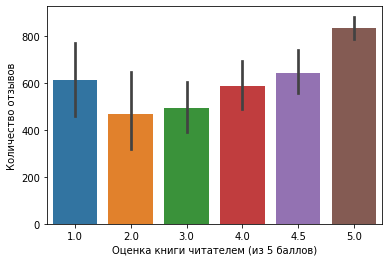

In [98]:
sns.barplot(rating, test["Количество отзывов"])

In [ ]:
train["Оценка книги читателем (из 5 баллов)"] = train["Оценка книги читателем (из 5 баллов)"].fillna(4)
test["Оценка книги читателем (из 5 баллов)"] = test["Оценка книги читателем (из 5 баллов)"].fillna(4)

In [109]:
train_length = train["Отзыв"].map(len)
test_length = test["Отзыв"].map(len)

In [110]:
train["length"] = train["Отзыв"].map(len)
test["length"] = test["Отзыв"].map(len)

In [111]:
train["Автор"] = pd.Categorical(train["Автор"])
train["Автор"].astype('category').cat.codes
train["Автор"] = train["Автор"].cat.codes

test["Автор"] = pd.Categorical(test["Автор"])
test["Автор"].astype('category').cat.codes
test["Автор"] = test["Автор"].cat.codes

## Построение графиков

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


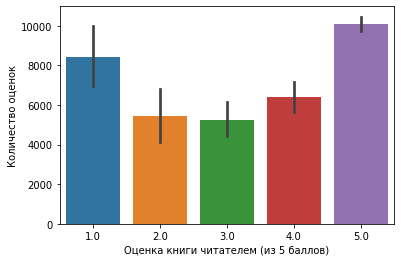

In [104]:
sns.barplot(train["Оценка книги читателем (из 5 баллов)"], train["Количество оценок"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


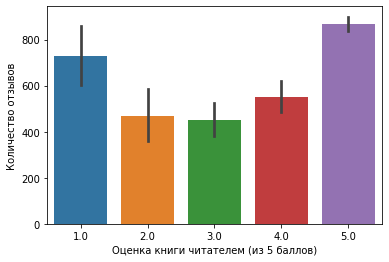

In [105]:
sns.barplot(train["Оценка книги читателем (из 5 баллов)"], train["Количество отзывов"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


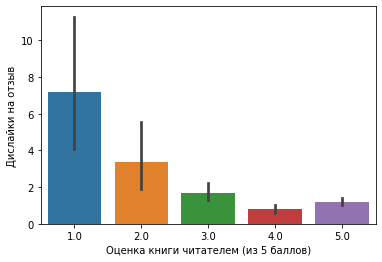

In [106]:
sns.barplot(train["Оценка книги читателем (из 5 баллов)"], train["Дислайки на отзыв"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


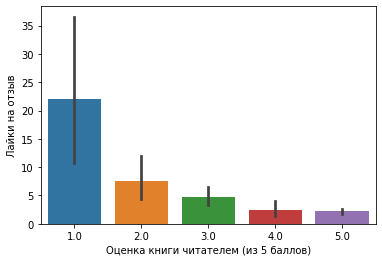

In [107]:
sns.barplot(train["Оценка книги читателем (из 5 баллов)"], train["Лайки на отзыв"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


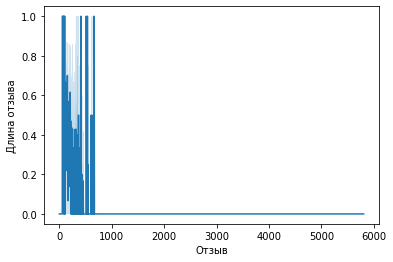

In [113]:
sns.lineplot(train_length, train['Длина отзыва'])

## Разделение на выборки

In [ ]:
y_labels = ['Релевантность',
       'Таксономия релевантные', 'Таксономия не релевантные',
       'Длина отзыва', 'Ценности']

In [ ]:
record = test["RecordNo"]

In [ ]:
X = train.drop(["Ссылка на литрес", "Название книги", "Имя читателя", "Отзыв", "RecordNo"], axis=1)
test = test.drop(["Ссылка на литрес", "Название книги", "Имя читателя", "Отзыв", "RecordNo"], axis=1)

In [ ]:
x1 = X.drop(y_labels, axis=1)
y1 = train[y_labels]

## Подбор гиперпараметров

In [ ]:
SEED = 42

def objective(trial, data=x1, target=y1['Релевантность']):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    
    params = {
        'metric': 'recall', 
        'random_state': SEED,
        'n_estimators': 10000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.75,0.8,0.85]),
        'subsample': trial.suggest_categorical('subsample', [0.6,0.65,0.7,0.75,0.8,0.85]),
        'learning_rate': trial.suggest_categorical('learning_rate', 
                                                   [0.005,0.006,0.008,0.01,0.015,0.02,0.03]),
        'max_depth': trial.suggest_categorical('max_depth', [-1,10,20]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    
    model = CatBoostClassifier(**params)      
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    recall = recall_score(y_test, preds, average="macro")
    
    return recall

In [ ]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=20)     

In [ ]:
clf = RandomForestClassifier(**study.best_trial.params)

In [ ]:
# max_depth=43, min_samples_leaf=2, min_samples_split=6, n_estimators=373 = 0.5424841602100299
# max_depth=94, min_samples_leaf=2, min_samples_split=7, n_estimators=851

In [ ]:
clf.fit(x1, y1['Релевантность'])

RandomForestClassifier(max_depth=73, min_samples_leaf=3, min_samples_split=54,
                       n_estimators=294)

In [ ]:
res = clf.predict(x1)

In [ ]:
recall_score(y1['Релевантность'], res, average="macro")

0.5976438505331353

## Feature Importance

In [ ]:
feature_names = [f"feature {i}" for i in range(x1.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(x1, y1)

RandomForestClassifier(random_state=0)

In [ ]:
x1.columns

Index(['Автор', 'Рейтинг', 'Количество оценок', 'Количество отзывов',
       'Оценка книги читателем (из 5 баллов)', 'Лайки на отзыв',
       'Дислайки на отзыв', 'Длина отзыва (числ.)'],
      dtype='object')

In [ ]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.023 seconds


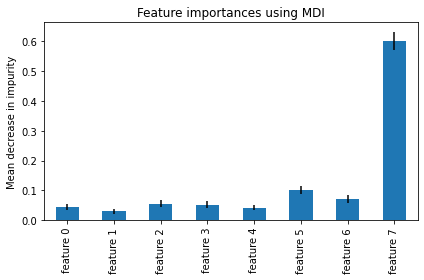

In [ ]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Попытки использовать различные классификаторы

In [114]:
clf = RandomForestClassifier()

In [ ]:
# max_depth=43, min_samples_leaf=2, min_samples_split=6, n_estimators=373 = 0.5424841602100299
# max_depth=94, min_samples_leaf=2, min_samples_split=7, n_estimators=851

In [ ]:
train_length_reshaped = train_length.values.reshape(-1, 1)

In [ ]:
train_length

In [ ]:
x1.info()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_length_reshaped, y1['Длина отзыва'], test_size=0.2, random_state=42)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
res = clf.predict(X_test)

In [ ]:
print("Recall score:", recall_score(y_test, res, average='macro'))

Recall score: 0.5104886712749616


In [ ]:
'''Recall score: 0.5496764668928258'''

## NLP (ruBERT)

In [7]:
device = torch.device("cuda")

In [8]:
train = pd.read_csv("train_dataset_train.csv")
test = pd.read_csv("test_dataset_test.csv")

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4839 entries, 0 to 4838
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RecordNo                              4839 non-null   int64  
 1   Название книги                        4839 non-null   object 
 2   Автор                                 4839 non-null   object 
 3   Ссылка на литрес                      4839 non-null   object 
 4   Рейтинг                               4839 non-null   float64
 5   Количество оценок                     4839 non-null   int64  
 6   Количество отзывов                    4839 non-null   int64  
 7   Имя читателя                          4839 non-null   object 
 8   Оценка книги читателем (из 5 баллов)  4070 non-null   float64
 9   Отзыв                                 4839 non-null   object 
 10  Лайки на отзыв                        4839 non-null   int64  
 11  Дислайки на отзыв

In [10]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
stop_words = set(stopwords.words("russian"))

In [12]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r' ',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', text)

def remove_punct(text):
    table=str.maketrans(" "," ",string.punctuation)
    return text.translate(table)

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r' ',text)

In [13]:
train["Отзыв"] = train["Отзыв"].apply(lambda x: x.lower())

In [14]:
train['Отзыв'] = train['Отзыв'].apply(lambda x : remove_url(x))
train['Отзыв'] = train['Отзыв'].apply(lambda x : remove_html(x))
train['Отзыв'] = train['Отзыв'].apply(lambda x : remove_emoji(x))
train['Отзыв'] = train['Отзыв'].apply(lambda x : remove_punct(x))

In [ ]:
train["Отзыв"].head(3)

In [16]:
train["Length"] = train["Отзыв"].map(len)

In [ ]:
train.head(1)

In [30]:
X = train[["Отзыв", "Length"]]

In [29]:
y_labels = ['Релевантность',
       'Таксономия релевантные', 'Таксономия не релевантные', 'Ценности']

In [19]:
record = test["RecordNo"]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [ ]:
model = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased")

model.to(device)

In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    eps=1e-8
)

In [ ]:
metric = load_metric("recall")

In [24]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [25]:
def tokenize_function_train_val(examples):
    return tokenizer(examples["Отзыв"], truncation=True, padding='max_length', max_length=50)

In [26]:
def tokenize_function_test(examples):
    return tokenizer(examples["Отзыв"], truncation=True, padding='max_length', max_length=50, return_tensors="pt")

In [27]:
d = {
    "RecordNo": record
    }

In [28]:
bad_recall = ['Длина отзыва']

In [33]:
test_length = test["Отзыв"].map(len)

In [56]:
good_train_length_df = train[train["Отзыв"].map(len) < 500]
good_train_length_df = good_train_length_df[good_train_length_df["Отзыв"].map(len) >= 100]
bad_train_length_df = train[train["Отзыв"].map(len) >= 500]
bad_train_length_df = bad_train_length_df[bad_train_length_df["Отзыв"].map(len) < 100]

In [44]:
good_test_length_df = test[test["Отзыв"].map(len) < 700]
bad_test_length_df = test[test["Отзыв"].map(len) >= 700]

In [57]:
train_x, val_x, train_y, val_y = train_test_split(good_train_length_df["Length"], good_train_length_df["Длина отзыва"], test_size=0.1)

In [58]:
train_x = train_x.values.reshape(-1, 1)
val_x = val_x.values.reshape(-1, 1)

In [ ]:
clf = CatBoostClassifier()
clf.fit(train_x, train_y)
pr = clf.predict(val_x)

In [70]:
recall_score(val_y, pr, average='macro')

0.5164469864127279

0.5322552549065149 - DecisionTree

0.5243438625014516 - RandomForest

0.5164469864127279 - CatBoost

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


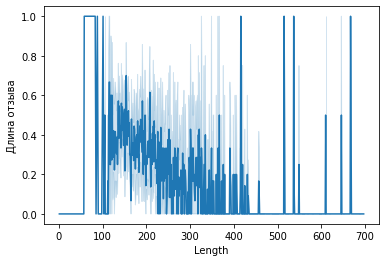

In [52]:
sns.lineplot(good_train_length_df["Length"], good_train_length_df["Длина отзыва"])

In [ ]:
for label in y_labels:
  train_df = train[["Отзыв", label]]
  train_df, val_df = train_test_split(train_df, test_size=0.1)
  test_df = test["Отзыв"]
  test_df = test_df.to_frame()

  train_dataset = Dataset.from_pandas(train_df)
  val_dataset = Dataset.from_pandas(val_df)
  test_dataset = Dataset.from_pandas(test_df)

  tokenized_train = train_dataset.map(tokenize_function_train_val)
  tokenized_val = val_dataset.map(tokenize_function_train_val)

  tokenized_test = test_dataset.map(tokenize_function_test)

  tokenized_train = tokenized_train.rename_column(label, 'label')
  tokenized_val = tokenized_val.rename_column(label, 'label')

  training_args = TrainingArguments(output_dir="test_trainer", 
                                  evaluation_strategy="epoch",
                                  learning_rate=2e-5,
                                  num_train_epochs=12,)
  
  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
  )

  trainer.train()

  tokenized_test = tokenized_test.to_dict()

  tokenized_test["input_ids"] = torch.Tensor(tokenized_test["input_ids"]).int()
  tokenized_test["attention_mask"] = torch.Tensor(tokenized_test["attention_mask"]).int()

  tokenized_test["input_ids"].to(device)
  tokenized_test["attention_mask"].to(device)

  model.eval()

  preds = []
  for x in range(len(tokenized_test["input_ids"])):
    with torch.no_grad():
      output = model(**{"input_ids": tokenized_test["input_ids"][x].cuda(), "attention_mask": tokenized_test["attention_mask"][x].cuda()})
      predictions = torch.argmax(output.logits, dim=-1)
      preds.append(predictions)

  for i in range(len(preds)):
    preds[i] = preds[i].cpu().detach().numpy()

  d[label] = preds

  shutil.rmtree("/content/test_trainer")
      

In [72]:
for i in d:
  if i == "RecordNo":
    continue
  else:
    x = d[i]
    for j in range(len(x)):
      x[j] =x[j][0]
    d[i] = x

In [ ]:
bad_test_length_df.head()

In [ ]:
bad_test_length_df["Length"] = bad_test_length_df["Отзыв"].map(len)
good_test_length_df["Length"] = good_test_length_df["Отзыв"].map(len)
good_test_df = good_test_length_df[["Length", "RecordNo"]]
bad_test_df = bad_test_length_df[["Length", "RecordNo"]]

In [87]:
gtl_reshaped = good_test_length_df["Length"].values.reshape(-1, 1)
good_results = clf.predict(gtl_reshaped)

In [ ]:
good = {}
for i, row in enumerate(good_test_df.iterrows()):
  good[row[1][1]] = good_results[i]

In [ ]:
bad = {}
for row in bad_test_df.iterrows():
  bad[row[1][1]] = 0

In [92]:
length_submit = []
for i in test["RecordNo"]:
  if i in good:
    length_submit.append(good[i])
  else:
    length_submit.append(bad[i])

In [93]:
d["Длина отзыва"] = length_submit

## Сабмит

In [94]:
predictions = pd.DataFrame(d)

In [95]:
predictions.head(3)

,RecordNo,Релевантность,Таксономия релевантные,Таксономия не релевантные,Ценности,Длина отзыва
0,3366,0,0,0,1,0
1,3952,0,1,0,0,0
2,6852,0,1,0,1,0


In [96]:
predictions.to_csv("predict_nlp.csv", sep=",", index=None)